### Variable Consistency Check

This notebook performs a **structural consistency audit** across all decoded survey files to identify variables that are **present in every survey month** from 2018 to 2024.

It follows the duplicate resolution and renaming step (`Duplicate_Handler.ipynb`) and serves as a **precondition for imputation**.

---
Purpose
- Identify variables that are **structurally consistent** across all survey waves.
- Prevent imputation on variables that were **not collected** in certain months.
- Provide a **presence matrix** and a **consistency profile** to guide downstream imputation and modeling.
---
Input
- Folder: `NEW Renamed Fully Decoded Surveys V2`  
(This folder contains harmonized survey files with duplicates already resolved.)

Output

- Folder: `NEW Variable Consistency Check V2`
 - `presence_matrix.csv`: binary matrix of variable presence across months
 - `consistency_profile.csv`: summary of variable presence rates and consistency tags

---

Consistency Criteria

A variable is considered **consistent** if it is present in **all survey months from 2018 to 2024**.  
Variables with partial presence are flagged as `partial` or `inconsistent` depending on their coverage.

This ensures that imputation is only applied to variables that were **intended to be collected** throughout the full time span.

In [1]:
import json
from pathlib import Path
import os
import pandas as pd
from collections import defaultdict
import matplotlib.pyplot as plt
import seaborn as sns

# Load config
with open(Path("./data/interim/config.json")) as f:
    cfg = json.load(f)

BASE_PATH = Path(cfg["BASE_PATH"])
INTERIM_DIR = Path(cfg["INTERIM_DIR"])
PROCESSED_DIR = Path(cfg["PROCESSED_DIR"])
LOG_DIR = Path(cfg["LOG_DIR"])
MONTH_ORDER = cfg["MONTH_ORDER"]

# Load inventory
with open(Path(INTERIM_DIR) / "inventory.json") as f:
    inventory = json.load(f)

In [2]:
import shutil

# Input and output folders (V2)
input_root = BASE_PATH / "NEW Renamed Fully Decoded Surveys V2"
output_root = BASE_PATH / "NEW Variable Consistency Check V2"

# --- NEW: IDEMPOTENT FOLDER CLEANUP ---
# This wipes out any "consistency_profile(1).csv" ghost files from previous runs
if output_root.exists():
    print(f" Cleaning existing consistency report folder: {output_root}")
    shutil.rmtree(output_root)

output_root.mkdir(parents=True, exist_ok=True)

print(f"Input folder: {input_root}")
print(f"Output folder created/verified: {output_root}")

 Cleaning existing consistency report folder: G:\.shortcut-targets-by-id\1VctTphaltRx4xcPxmTJlRTrxLalyuEt8\Labor Force Survey\NEW Variable Consistency Check V2
Input folder: G:\.shortcut-targets-by-id\1VctTphaltRx4xcPxmTJlRTrxLalyuEt8\Labor Force Survey\NEW Renamed Fully Decoded Surveys V2
Output folder created/verified: G:\.shortcut-targets-by-id\1VctTphaltRx4xcPxmTJlRTrxLalyuEt8\Labor Force Survey\NEW Variable Consistency Check V2


In [3]:
# Track variable presence across months
presence = defaultdict(set)
all_months = []

for year in sorted(os.listdir(input_root)):
    year_folder = input_root / year
    if not year_folder.is_dir():
        continue

    for file in sorted(os.listdir(year_folder)):
        if not file.lower().endswith(".csv"):
            continue

        month = file.split("_")[0].capitalize()
        month_year = f"{month} {year}"
        all_months.append(month_year)

        file_path = year_folder / file
        try:
            df = pd.read_csv(file_path, nrows=1)
            for col in df.columns:
                presence[col.strip()].add(month_year)
        except Exception as e:
            print(f"[ERROR] Failed to read {file_path}: {e}")

all_months = sorted(set(all_months), key=lambda x: (int(x.split()[1]), MONTH_ORDER.get(x.split()[0], 99)))
all_vars = sorted(presence.keys())

In [4]:
# Build binary presence matrix
presence_matrix = pd.DataFrame(0, index=all_vars, columns=all_months)

for var in all_vars:
    for month in presence[var]:
        presence_matrix.loc[var, month] = 1

# Save presence matrix
presence_matrix.to_csv(output_root / "presence_matrix.csv")

# Build consistency profile
total_months = len(all_months)
profile = []

for var in all_vars:
    months_present = presence[var]
    presence_rate = len(months_present) / total_months

    if presence_rate == 1.0:
        tag = "consistent"
    elif presence_rate >= 0.7:
        tag = "partial"
    else:
        tag = "inconsistent"

    profile.append({
        "Variable": var,
        "MonthsPresent": sorted(months_present),
        "PresenceRate": round(presence_rate, 4),
        "ConsistencyTag": tag
    })

# Convert to DataFrame and sort
consistency_df = pd.DataFrame(profile)
consistency_df = consistency_df.sort_values(
    by=["ConsistencyTag", "PresenceRate", "Variable"],
    ascending=[True, False, True]
)

# Save consistency profile
consistency_df.to_csv(output_root / "consistency_profile.csv", index=False)

print(f"\nConsistency check complete.")
print(f"- Total variables scanned: {len(all_vars)}")
print(f"- Consistent variables: {(consistency_df['ConsistencyTag'] == 'consistent').sum()}")
print(f"- Partial variables: {(consistency_df['ConsistencyTag'] == 'partial').sum()}")
print(f"- Inconsistent variables: {(consistency_df['ConsistencyTag'] == 'inconsistent').sum()}")



Consistency check complete.
- Total variables scanned: 76
- Consistent variables: 21
- Partial variables: 7
- Inconsistent variables: 48


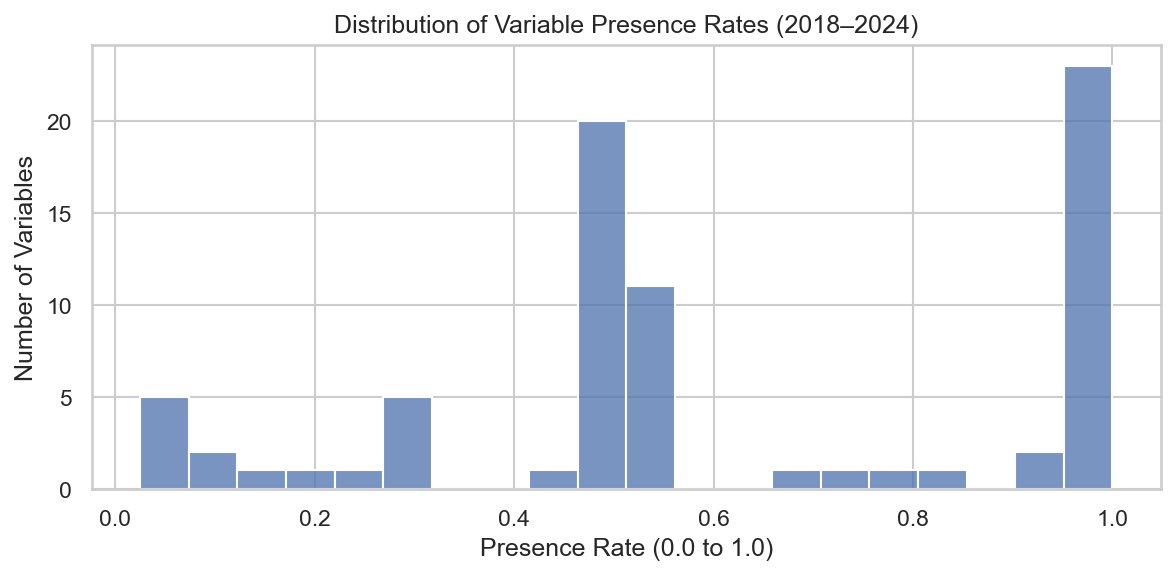

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set global style and resolution
sns.set(style="whitegrid")
plt.rcParams["figure.dpi"] = 150

# --- Plot 1: Distribution of Presence Rates ---
plt.figure(figsize=(8, 4))
sns.histplot(consistency_df["PresenceRate"], bins=20, kde=False, color="#4C71AC")
plt.title("Distribution of Variable Presence Rates (2018–2024)")
plt.xlabel("Presence Rate (0.0 to 1.0)")
plt.ylabel("Number of Variables")
plt.tight_layout()
plt.show()

C:\Users\Faith\AppData\Local\Temp\ipykernel_28536\2132372495.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=consistency_df, x="ConsistencyTag", palette="muted", order=["consistent", "partial", "inconsistent"])


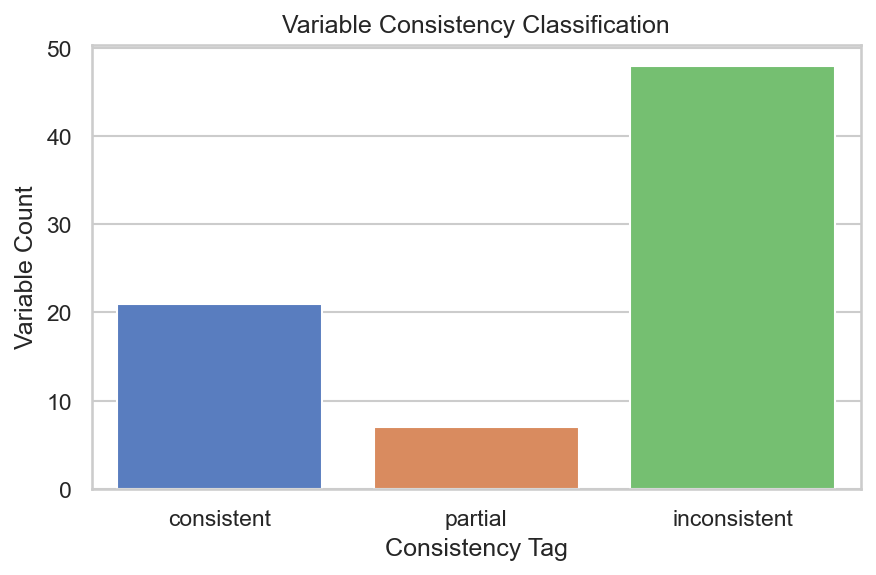

In [6]:
# --- Plot 2: Count of Variables by Consistency Tag ---
plt.figure(figsize=(6, 4))
sns.countplot(data=consistency_df, x="ConsistencyTag", palette="muted", order=["consistent", "partial", "inconsistent"])
plt.title("Variable Consistency Classification")
plt.xlabel("Consistency Tag")
plt.ylabel("Variable Count")
plt.tight_layout()
plt.show()


In [7]:
# --- FINAL CONSISTENCY REPORT (NEAT FORMAT) ---
MAX_VAR_WIDTH = 50  # Adjust this if you want longer or shorter names
print("\n" + "="*85)
print(f"{'VARIABLE':<{MAX_VAR_WIDTH}} | {'MONTHS':<8} | {'RATE':<8} | {'STATUS'}")
print("-" * 85)

total_possible_months = len(all_months)

for _, row in consistency_df.iterrows():
    raw_var_name = str(row['Variable'])
    
    # Truncate long variable names to keep the table neat
    if len(raw_var_name) > MAX_VAR_WIDTH:
        display_name = raw_var_name[:MAX_VAR_WIDTH-3] + "..."
    else:
        display_name = raw_var_name
        
    months_count = len(row['MonthsPresent'])
    presence_rate = (months_count / total_possible_months) * 100
    tag = row['ConsistencyTag'].upper()
    
    # Clean status text
    status_text = tag
    
    print(f"{display_name:<{MAX_VAR_WIDTH}} | {months_count:<8} | {presence_rate:>6.1f}% | {status_text}")

print("="*85)
print(f"Timeline: {all_months[0]} to {all_months[-1]}")
print(f"Total Reference Months: {total_possible_months}")


VARIABLE                                           | MONTHS   | RATE     | STATUS
-------------------------------------------------------------------------------------
Available for Work                                 | 40       |  100.0% | CONSISTENT
C03-Relationship to Household Head                 | 40       |  100.0% | CONSISTENT
C04-Sex                                            | 40       |  100.0% | CONSISTENT
C05-Age as of Last Birthday                        | 40       |  100.0% | CONSISTENT
C06-Marital Status                                 | 40       |  100.0% | CONSISTENT
C07-Highest Grade Completed                        | 40       |  100.0% | CONSISTENT
C101-Line Number                                   | 40       |  100.0% | CONSISTENT
Household Size                                     | 40       |  100.0% | CONSISTENT
Look for Additional Work                           | 40       |  100.0% | CONSISTENT
Looked for Work or Tried to Establish Business ... | 40       |  1